In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 
from util_notebook import *

# Get celebA dataset

# dataset

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [6]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [7]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [8]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [9]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

In [10]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


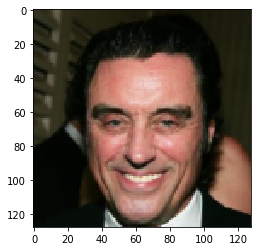

In [11]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

# conditional GAN

In [12]:
torch.cuda.set_device("cuda:2")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# ---- adjustable parameters ---- #
ndim = 8
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4
save_parameter = True
###################################

ref_label = np.eye(len(classes))
criterion = nn.MSELoss()

## train

In [14]:
get_adjustable_parameters(1)

restriction_type unrolled_k idt_reg
0   conventionalKL          1       0
1       preposedKL          1       0
2       preposedKL          5     0.5

In [98]:
###############################################
############ adjustable parameters ############

restriction_type = "conventionalKL" # "conventionalKL", "proposedKL"
lbd_idt_reg = 0
unrolled_k = 1

###############################################
###############################################

if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu"
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu"

lbd = {}
lbd["cycle"] = 5
lbd["idt"] = 5
lbd["KL"] = 0.1
lbd["reg"] = 0.5
lbd["idt_reg"] = lbd_idt_reg
    
if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1
    lbd["batch_KL"] = 0
    lbd["corr_enc"] = 0
    lbd["hist"] = 0
elif restriction_type == "proposedKL":
    lbd["KL"] = 0
    lbd["batch_KL"] = 10
    lbd["corr_enc"] = 100
    lbd["hist"] = 100

In [99]:
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
netD = []
for i in classes:
    netD.append(SingleDiscriminator_original_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance").to(device))
sg = SingleGAN_training([netG, netD, netE], criterion, lbd, unrolled_k, device, ref_label, None, ndim, classes)
sg.opt_sche_initialization()

In [100]:
load_epoch = 30
dir = "./../data/parameters/01/"
# dir = "./instant_model_parameter/"

gen_path = f"{dir}gen_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
enc_path = f"{dir}enc_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"

gen_model = torch.load(gen_path)
enc_model = torch.load(enc_path)
netG.load_state_dict(gen_model)
netE.load_state_dict(enc_model)

<All keys matched successfully>

In [101]:
num = 100
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [102]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False)
for itr, data in enumerate(dataloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    
    class_vector = class_encode(data_label, device, sg.ref_label)
    _, mu, _, = netE(data_image, class_vector)
    if itr==0:
        samples = cuda2cpu(data_image)
        labels = cuda2cpu(data_label)
        mu_list = cuda2cpu(mu)
    else:
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        mu_list = np.concatenate([mu_list, cuda2cpu(mu)], axis=0)
latent = np.random.randn(num, ndim)

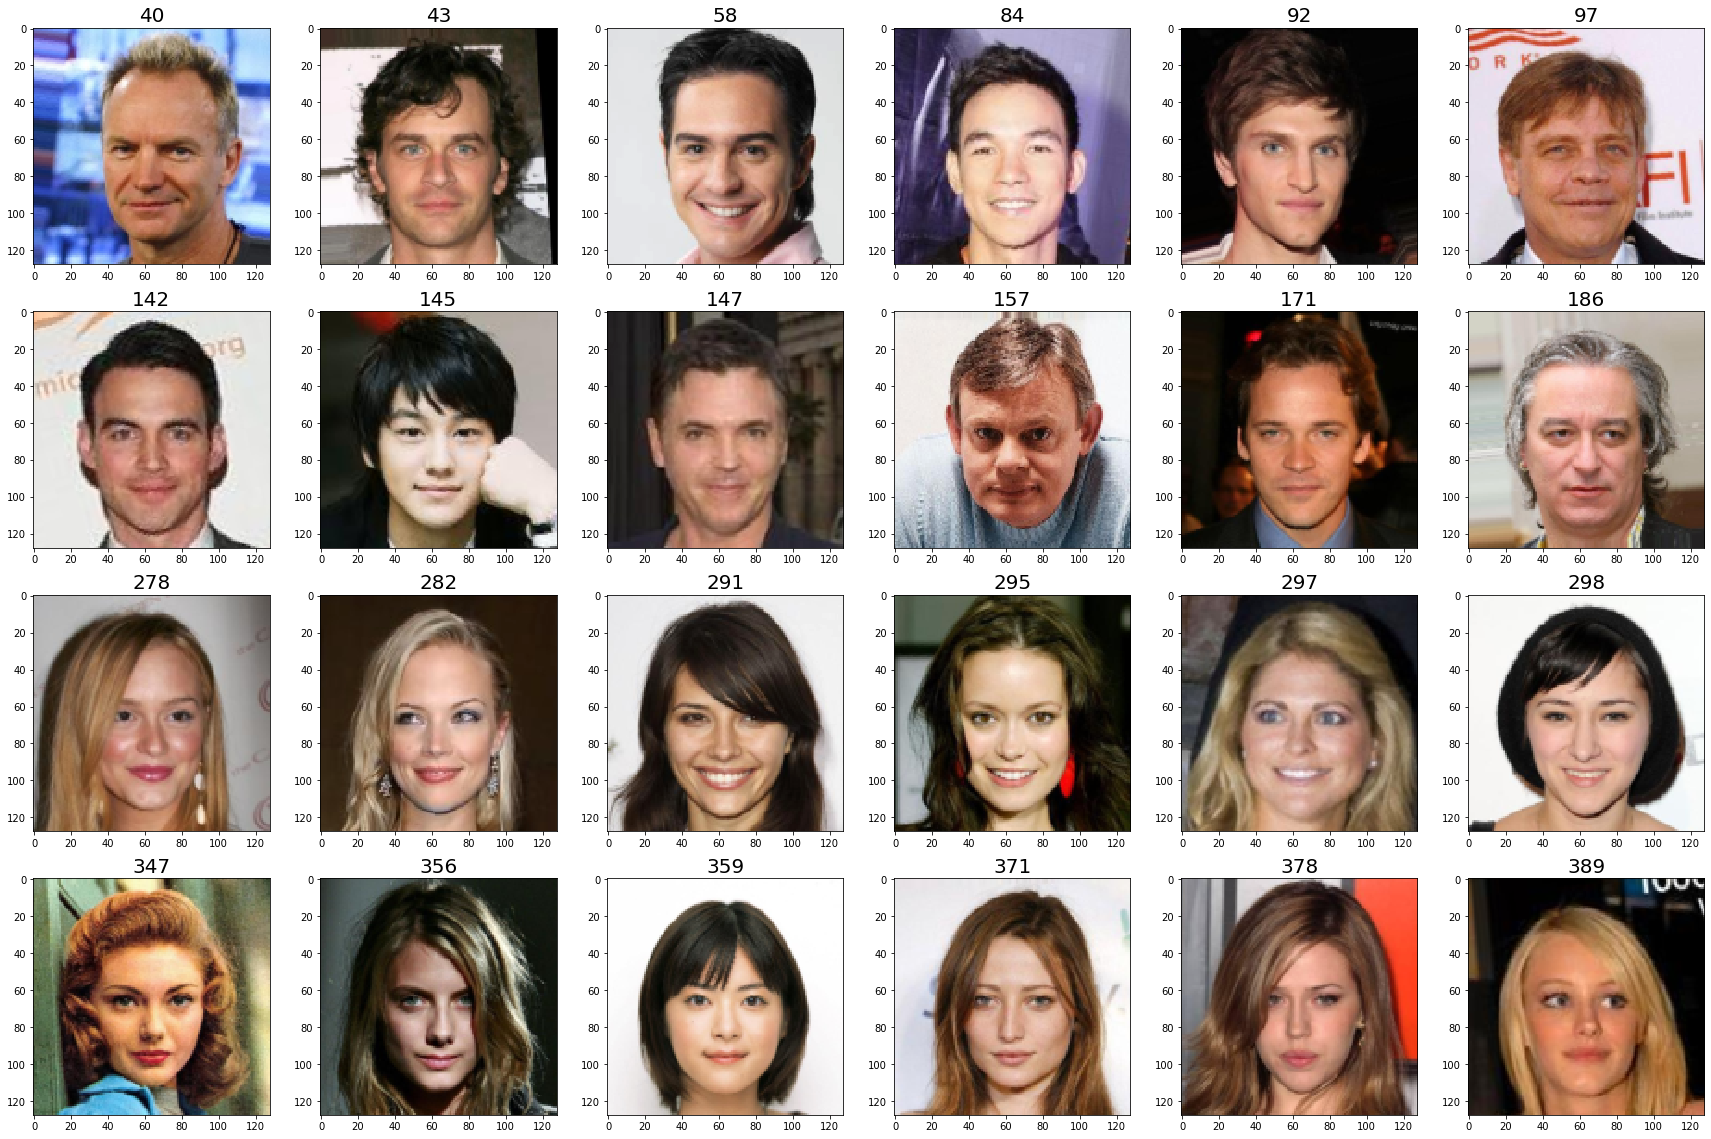

In [30]:
index_list = {}
index_list[0] = [num*1-3, num*1-8, num*1-16, num*1-42, num*1-57, num*1-60]
index_list[1] = [num*2-14, num*2-29, num*2-43, num*2-53, num*2-55, num*2-58]
index_list[2] = [num*3-2, num*3-3, num*3-5, num*3-9, num*3-18, num*3-22]
index_list[3] = [num*4-11, num*4-22, num*4-29, num*4-41, num*4-44, num*4-53]
for i in classes:
    index_list[i].sort()
    
length = len(classes)
width = len(index_list[0])

fig = plt.figure(figsize=(5*width, 5*length))

for i in range(length):
    for j in range(width):
        ax = fig.add_subplot(length, width, i*width+j+1)
        index = index_list[i][j]
        image = testset[index][0]
        image = image_from_output(image.unsqueeze(0))[0]
        ax.imshow(image)
        ax.set_title(index, fontsize=20)

In [31]:
idx = 142
# idx = 145
# idx = 359
# idx = 389
latent_list = latent
data, label = get_samples(netG, netE, testset, idx, latent_list, classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=True)

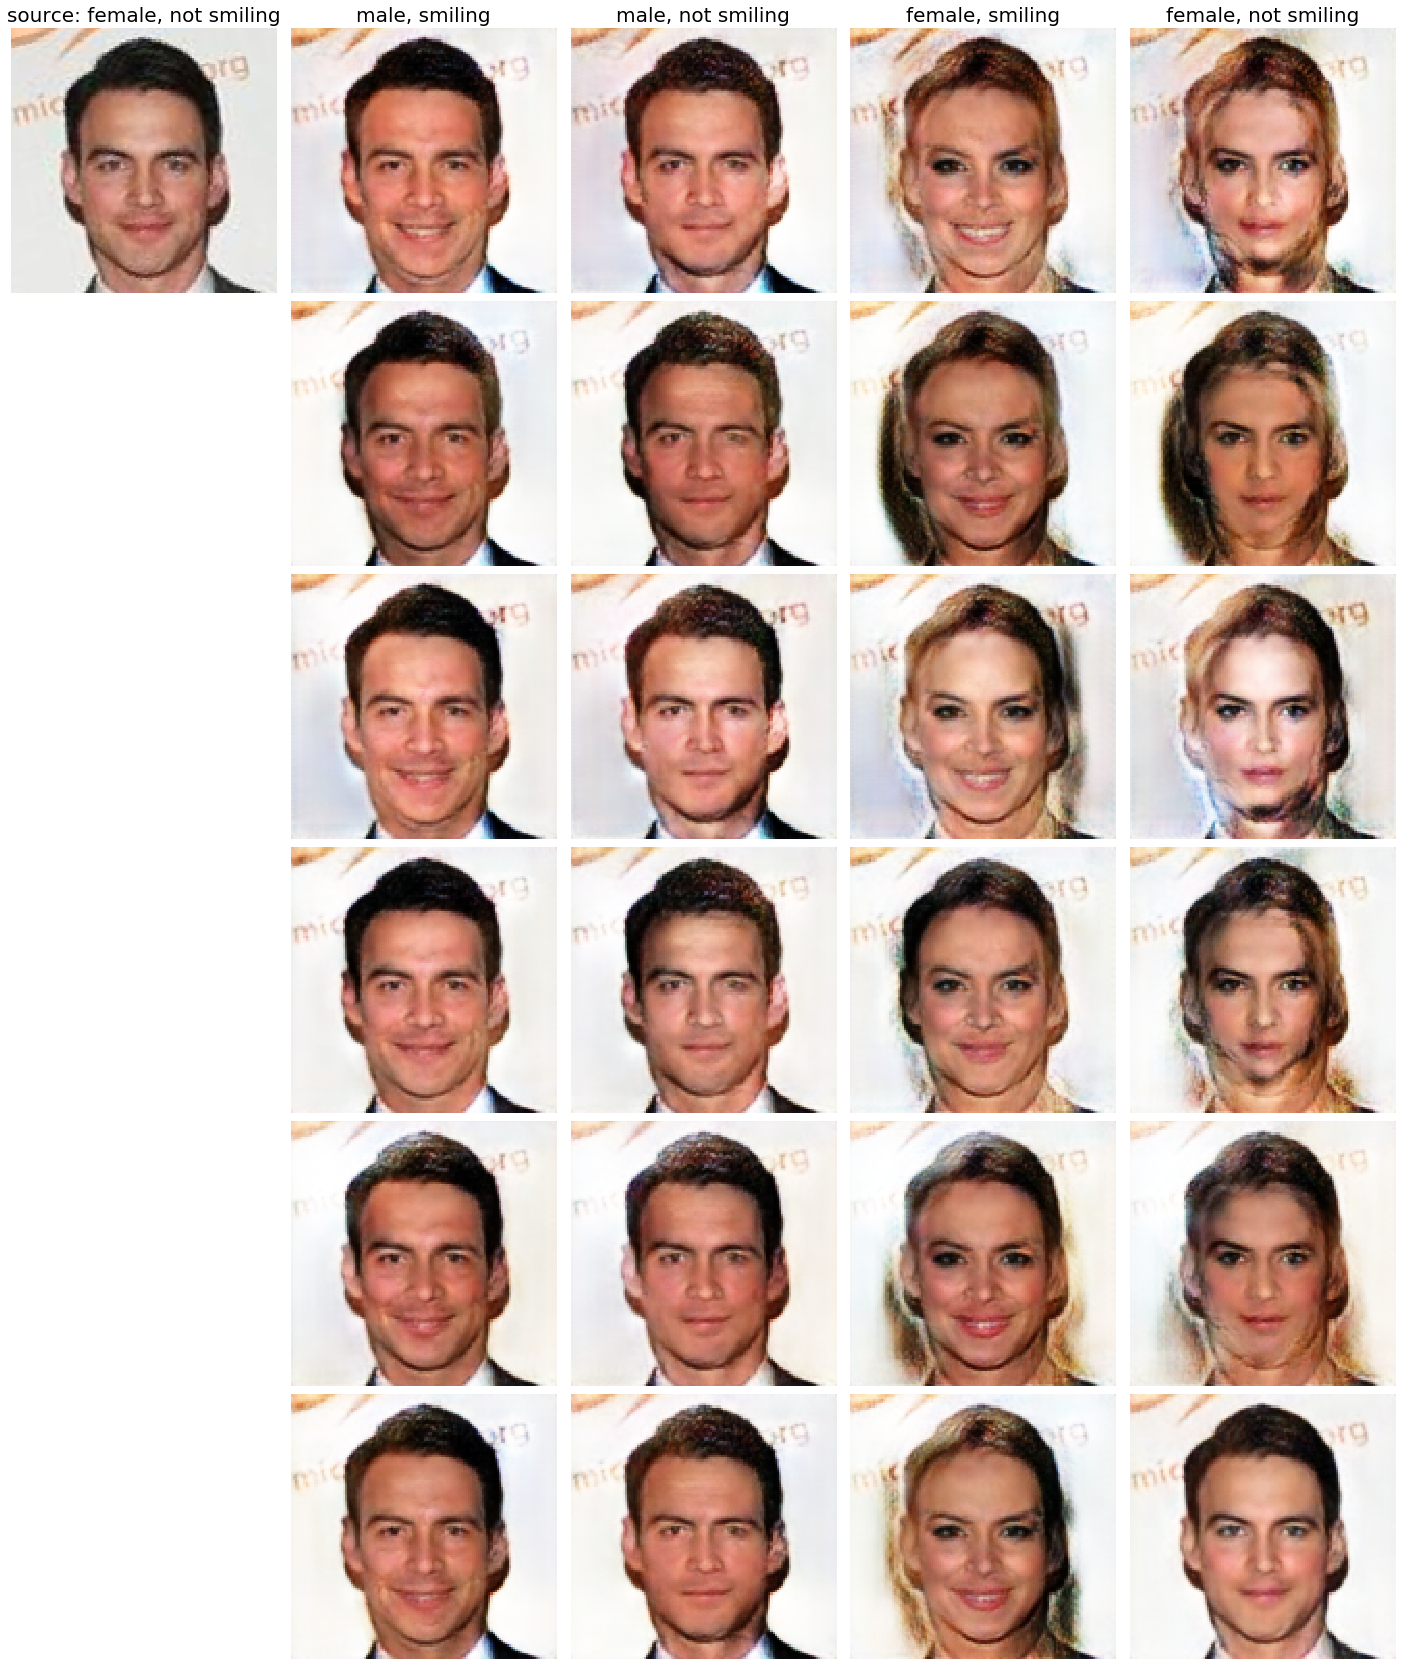

In [32]:
length = 6
images = data["target"]

width = len(classes)+1
fig = plt.figure(figsize=(5*width, 5*length))
np.random.seed(1)
a = np.random.choice(np.arange(num), length, False)
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title(f"source: {label_discription[3]}", fontsize=20)
plt.axis('off')

for i in range(length):
    for j in classes:
        index = i*(len(classes)+1)+j+2
        ax = fig.add_subplot(length, width, index)
        ax.imshow(images[j][a[i]])
        if i == 0:
            ax.set_title(label_discription[j], fontsize=20)
        plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

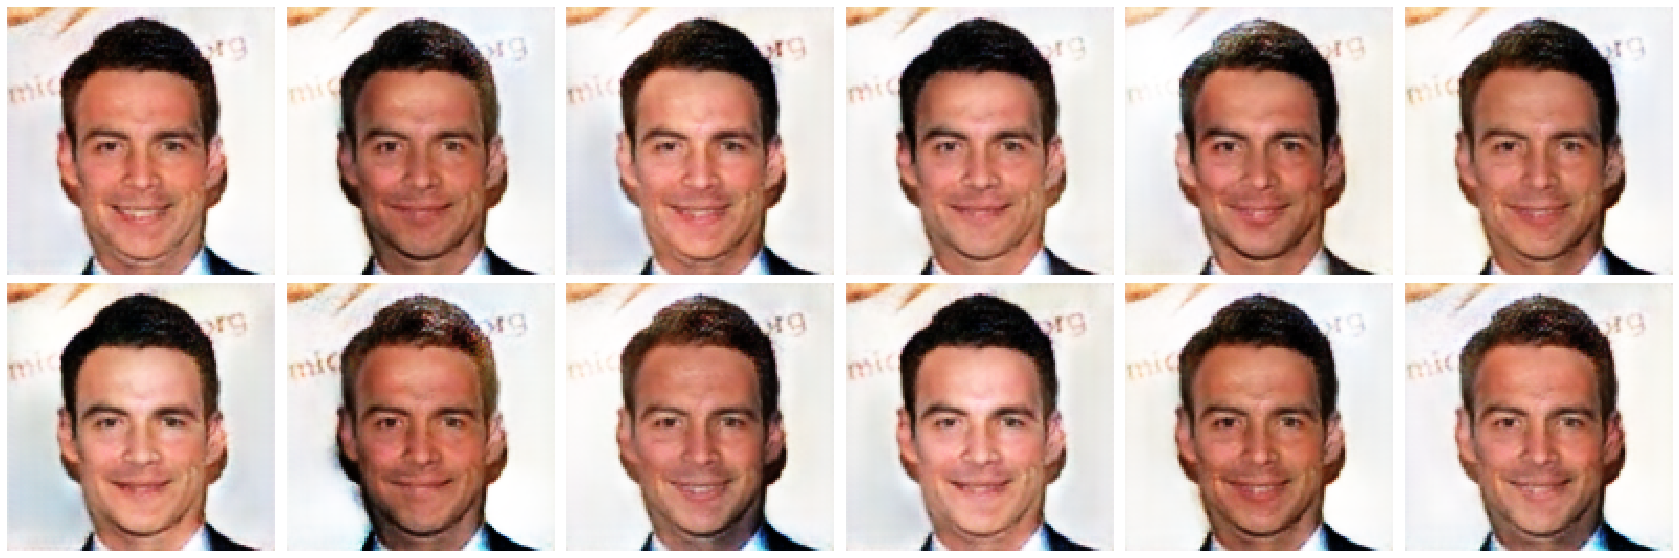

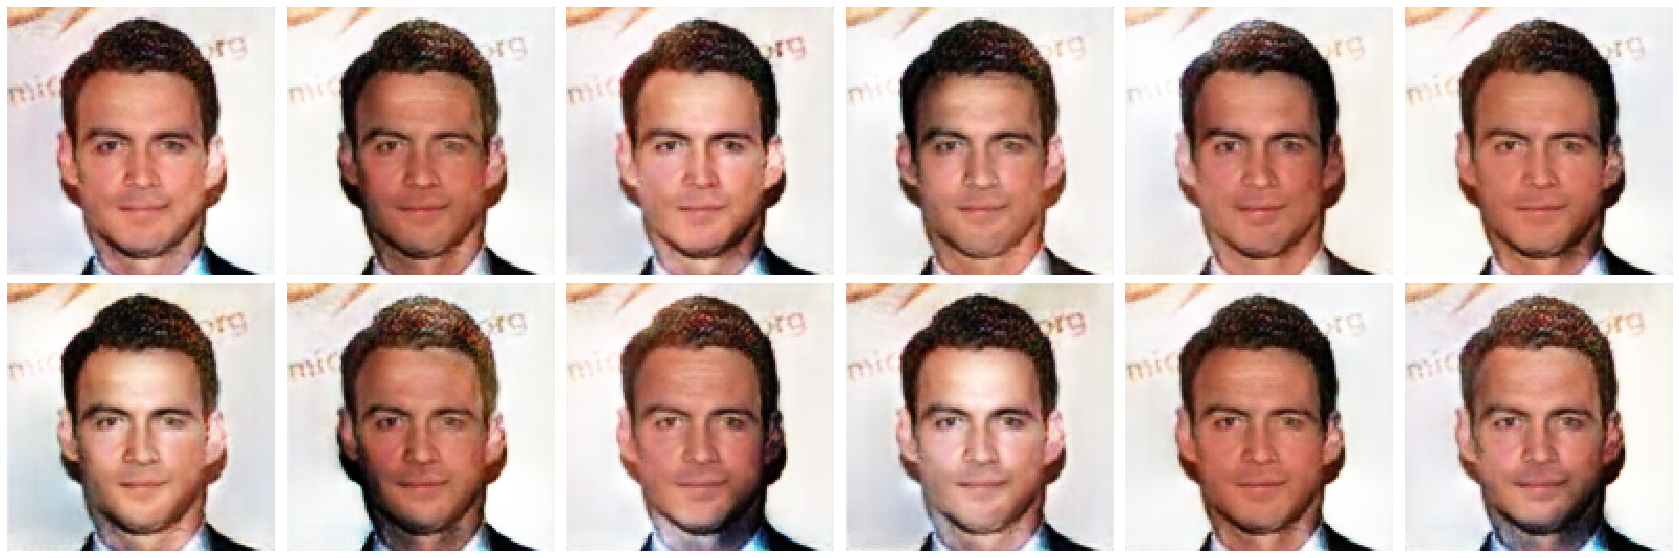

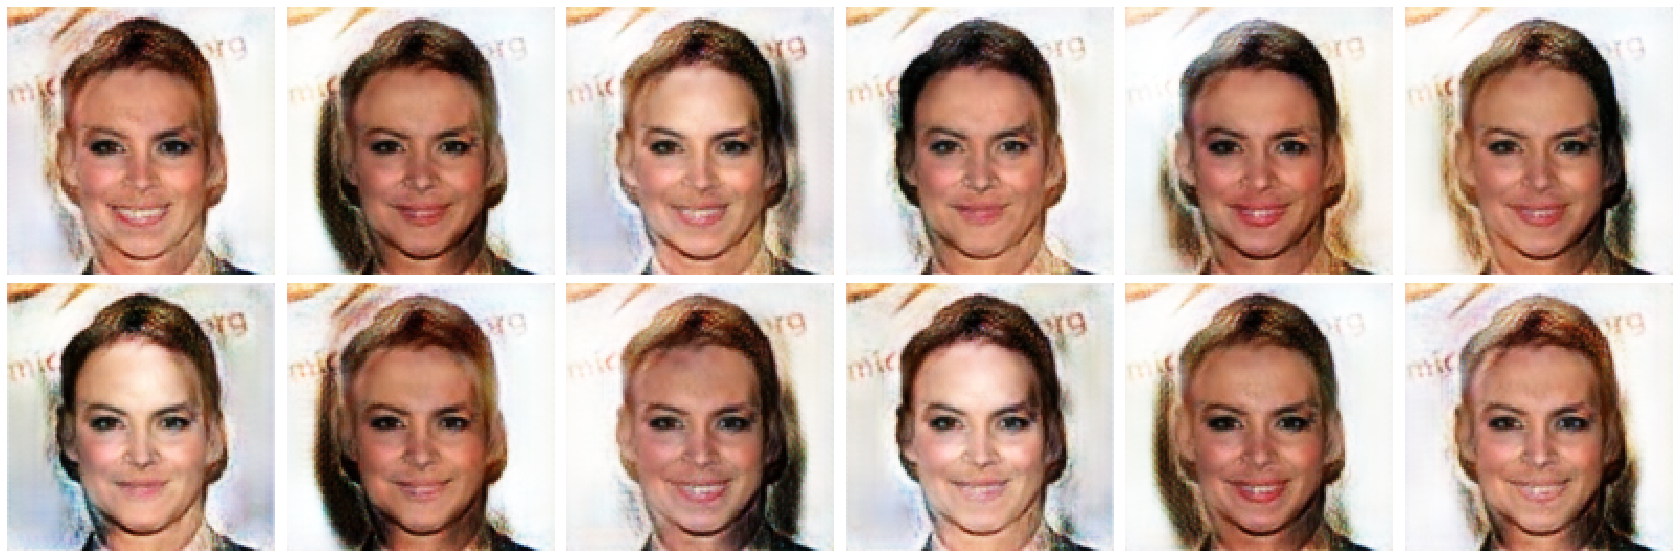

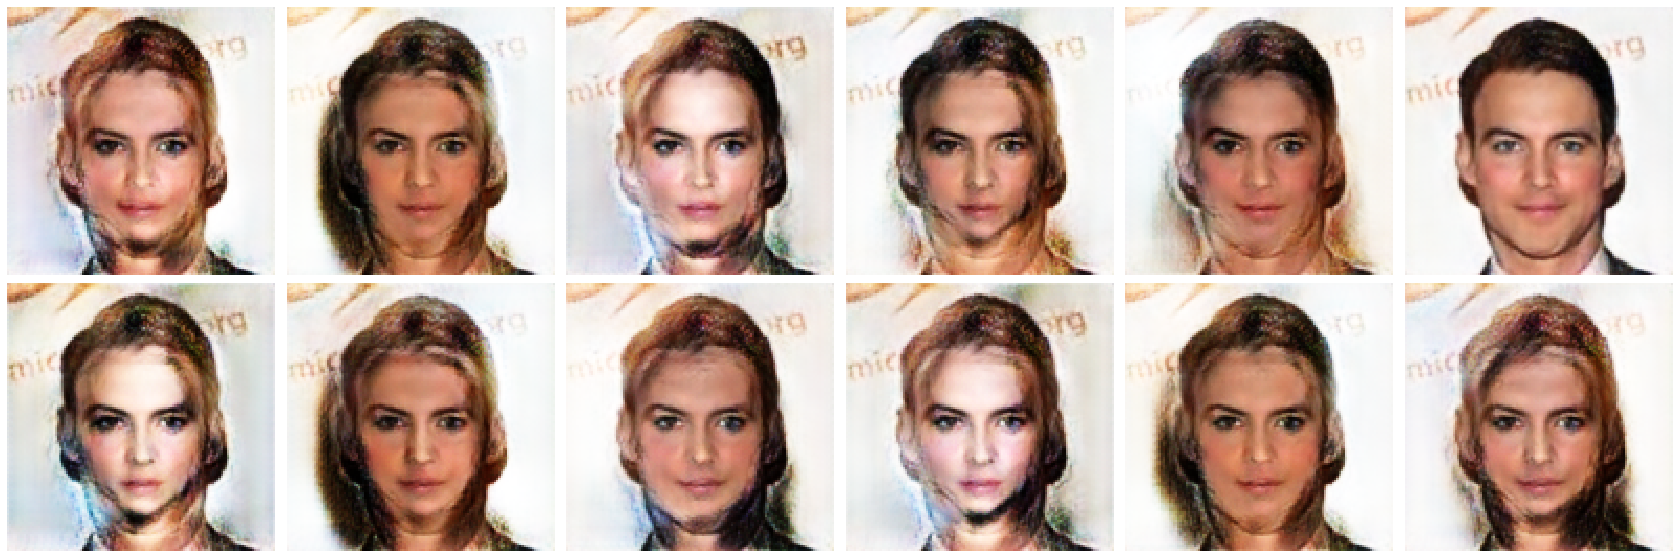

In [33]:
each_length = 2
width = 6
images = data["target"]

save = False
save_dir = "../data/results/images/01/"

np.random.seed(1)
a = np.random.choice(np.arange(num), width*each_length, False)

for i in classes:
    fig = plt.figure(figsize=(5*width, 5*each_length))
    for j in range(each_length):
        for k in range(width):
            index = j*width+k+1
            ax = fig.add_subplot(each_length, width, index)
            ax.imshow(images[i][a[j*width+k]])
#                 if i == 0:
#                     ax.set_title(label_discription[j], fontsize=20)
            plt.axis('off')
    plt.subplots_adjust(wspace=0.01, hspace=0.03)
    if save:
        save_path = save_dir + f"result_{restriction_type}_{unrolled_k}_{lbd['idt_reg']}_index{idx}_class{i}.png"
        plt.savefig(fname=save_path, format="png")

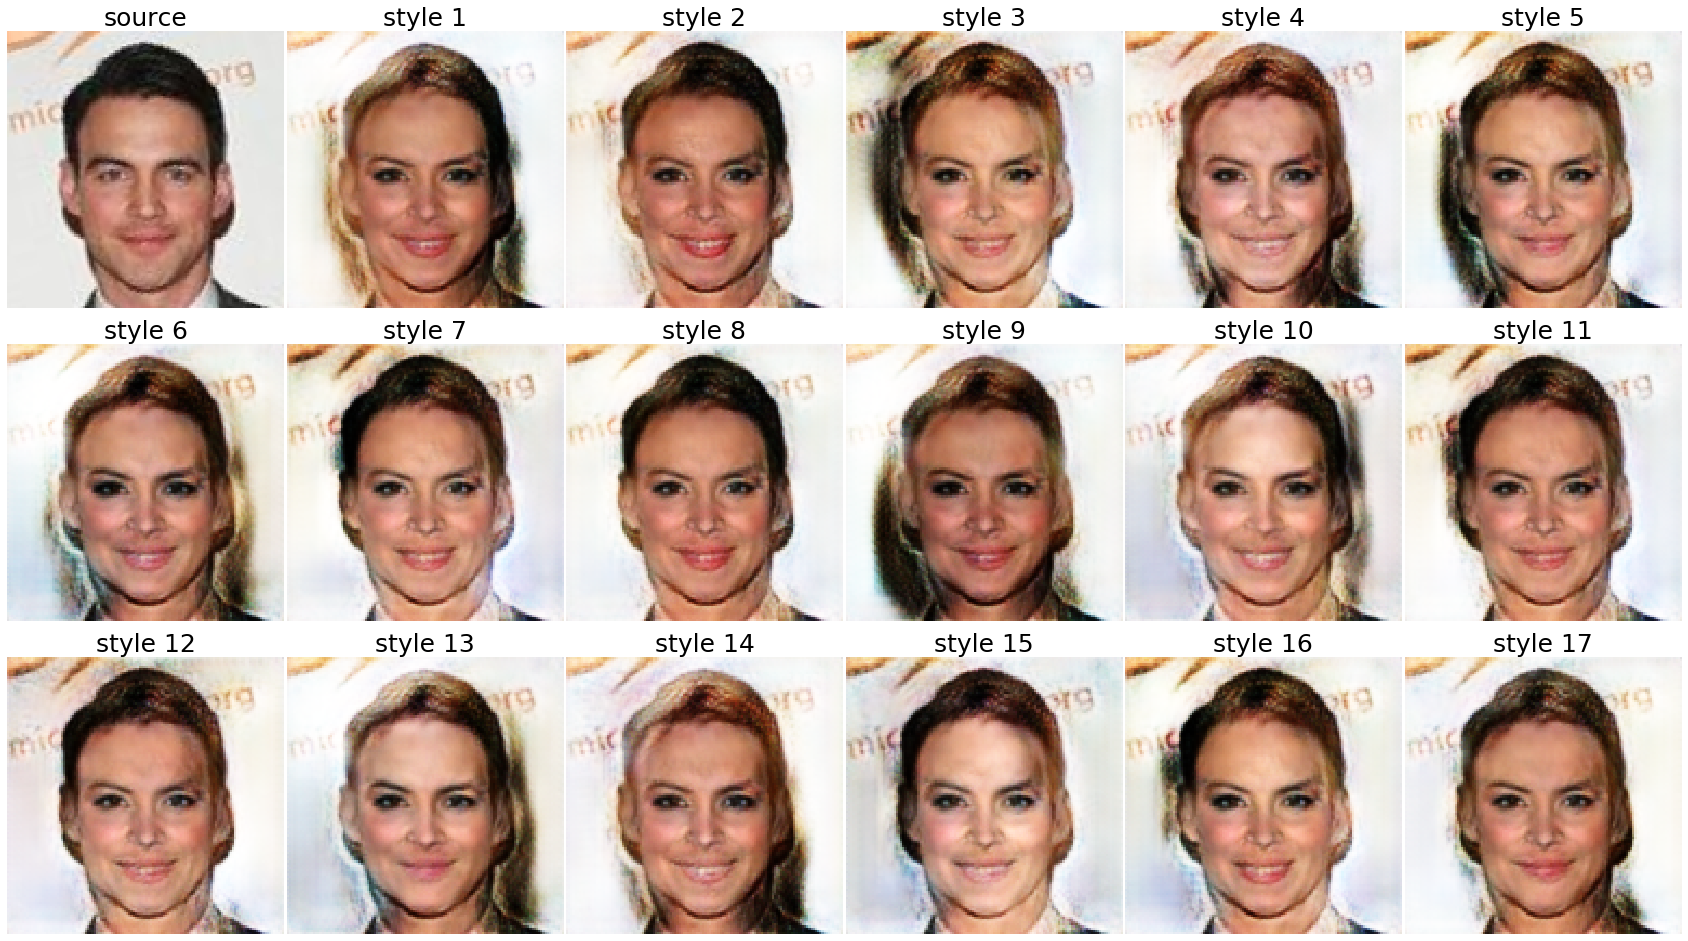

In [34]:
length = 3
width = 6
target_label = 2
if restriction_type=="conventionalKL" and unrolled_k==1 and lbd['idt_reg']==0:
    save = True
else:
    save = False
save_dir = "../data/results/images/01/"

images = data["target"][target_label]
np.random.seed(8)
a = np.random.choice(np.arange(num), length*width, False)
fig = plt.figure(figsize=(5*width, 5.7*length))

index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source", fontsize=25)
plt.axis('off')

for i in range(length*width-1):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images[a[i]])
    ax.set_title(f"style {i+1}", fontsize=25, )
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)
if save:
    save_path = save_dir + f"representative_index{idx}_conventional_SingleGAN.png"
    plt.savefig(fname=save_path, format="png")

## Encoder

### Restriction Distribution

In [ ]:
import seaborn as sns

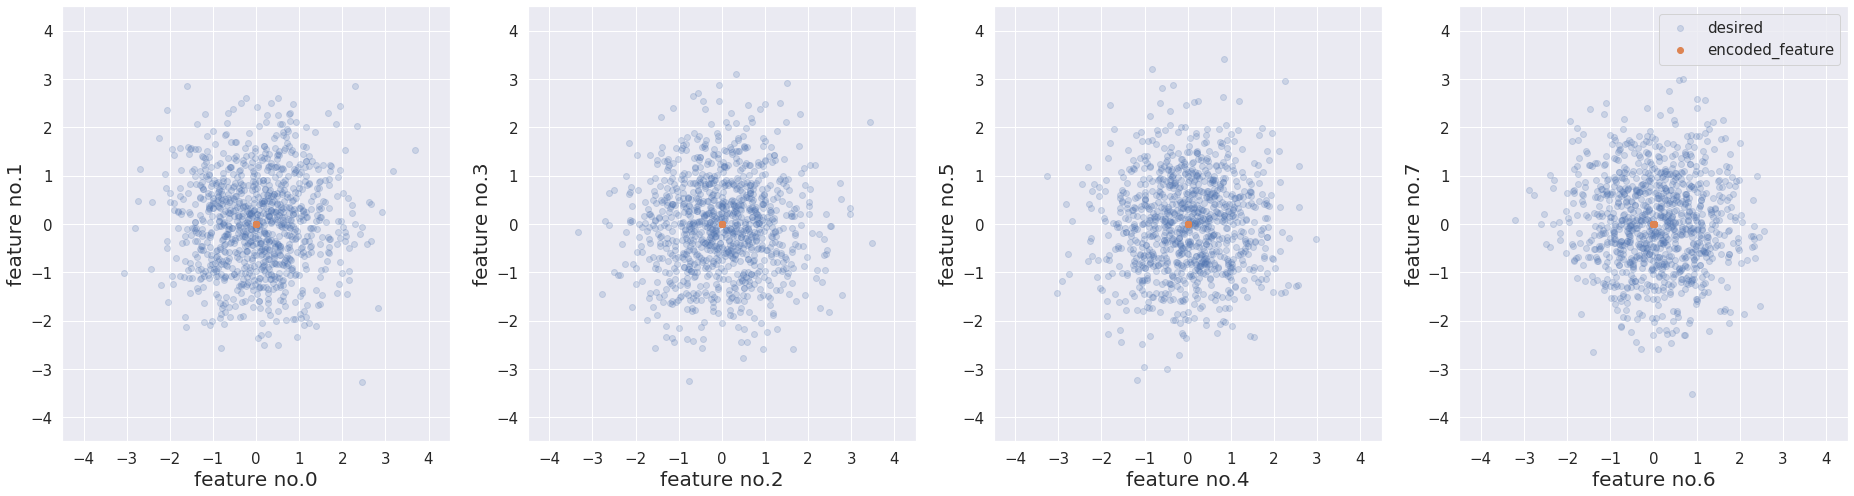

In [103]:
length = 1
width = 4
save = True
save_dir = "../data/results/images/01/"

sns.set()
a = torch.randn(1000, 8)
b = torch.tensor(mu_list)

fig = plt.figure(figsize=(8*width, 8*length))
for i in range(length*width):
    ax = fig.add_subplot(length, width, i+1)
    ax.scatter(a[:,2*i], a[:,2*i+1], alpha=0.2, label="desired")
    ax.scatter(b[:,2*i], b[:,2*i+1], label="encoded_feature")
    ax.set_xlabel(f"feature no.{2*i}", fontsize=20)
    ax.set_ylabel(f"feature no.{2*i+1}", fontsize=20)
    if i == 3:
        plt.legend(fontsize=15)
    plt.xlim(-4.5, 4.5)
    plt.ylim(-4.5, 4.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
if save:
    save_path = save_dir + f"encoded_features_distribution_{restriction_type}_unrolledk{unrolled_k}_idtreg{lbd['idt_reg']}.png"
    plt.savefig(fname=save_path, format="png")

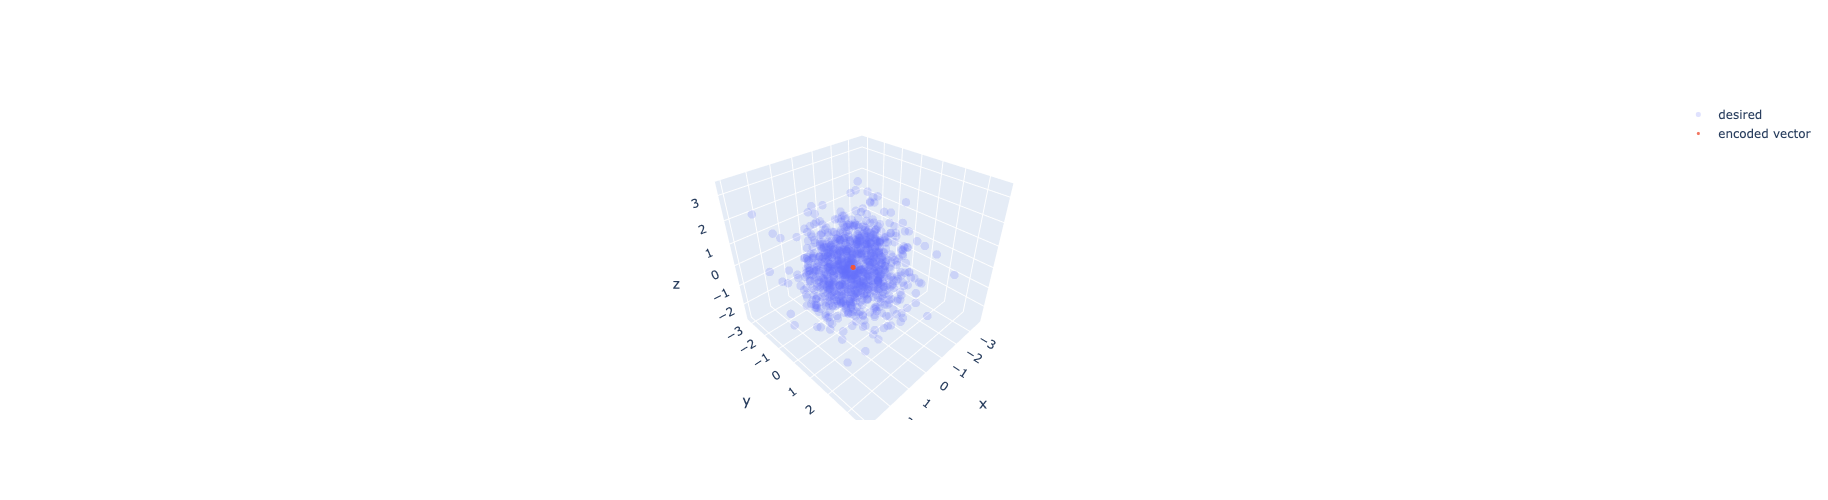

In [104]:
sample_num = 1000

trace = []
m = np.random.randn(1000, 3)
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"desired", 
                          marker = dict(size=5, opacity=0.2)))

m = mu_list[:sample_num,0:]
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"encoded vector", 
                          marker = dict(size=3, opacity=0.8)))


layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

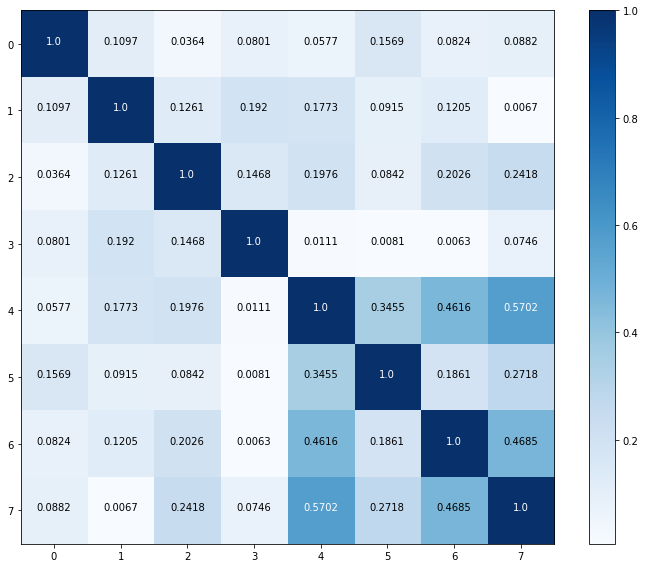

In [105]:
sns.reset_orig()
def plot_correlation_matrix(cm, save=False, save_dir="", save_name=""):
    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j], 4)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    if save:
        save_path = save_dir + save_name
        plt.savefig(fname=save_path, format="png")
    plt.show()
    return

save = True
save_dir = "../data/results/images/01/"
save_name = f"encoded_features_correlation_matrix{restriction_type}_unrolledk{unrolled_k}_idtreg{lbd['idt_reg']}.png"
plot_correlation_matrix(np.abs(np.array(corrcoef(torch.tensor(mu_list.T)))), save, save_dir, save_name)

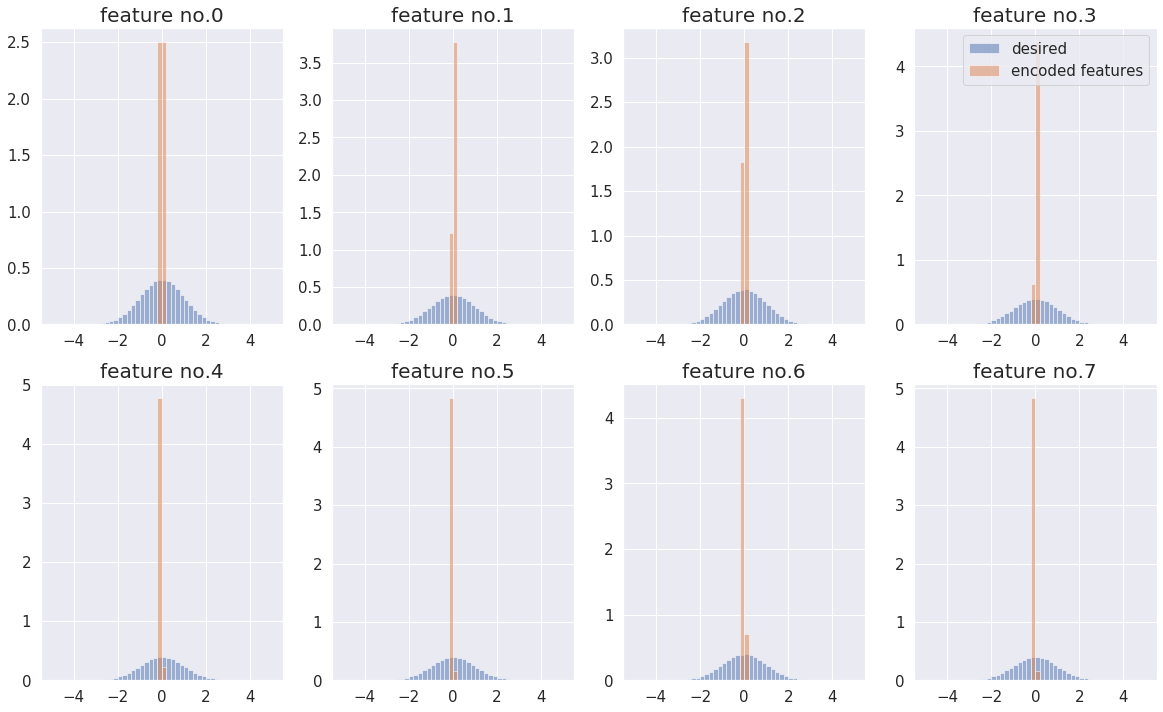

In [106]:
length = 2
width = 4
save = True
save_dir = "../data/results/images/01/"

a = torch.randn(100000, 1)
b = torch.tensor(mu_list)
sns.set()

range_max = 5
bins = 50

fig = plt.figure(figsize=(5*width, 6*length))
for i in range(length*width):
    ax = fig.add_subplot(length, width, i+1)
    ax.hist(cuda2numpy(a[:,0]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="desired")
    ax.hist(cuda2numpy(b[:,i]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="encoded features")
    if i ==3:
        plt.legend(fontsize=15)
    ax.set_title(f"feature no.{i}", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
if save:
    save_path = save_dir + f"encoded_features_histogram_{restriction_type}_unrolledk{unrolled_k}_idtreg{lbd['idt_reg']}.png"
    plt.savefig(fname=save_path, format="png")

### data

In [25]:
num = 1000
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [26]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1000, shuffle=False)
for itr, data in enumerate(dataloader):
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if itr==0:
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)

In [27]:
index = len(testset) - 11

latent = np.random.randn(num, ndim)
data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)

## PRDC

### evaluation

In [28]:
fe_list = ["vgg-initialization", 
           "vgg-ImageNet", 
           "vgg-CelebA"]

In [29]:
from evaluation import *

In [30]:
ge = GAN_evaluation(fe_list[0], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.983, 'recall': 0.0, 'density': 1.0342, 'coverage': 0.105}

In [31]:
ge = GAN_evaluation(fe_list[1], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 0.88,
 'recall': 0.0,
 'density': 0.7192000000000001,
 'coverage': 0.072}

In [32]:
ge = GAN_evaluation(fe_list[2], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 1.0,
 'recall': 0.119,
 'density': 0.8852000000000001,
 'coverage': 0.114}

In [33]:
def evaluation_init(fe_list, classes, metrics):
    GAN_eval = {}
    for fe in fe_list:
        GAN_eval[fe] = {}
        for source_label in classes:
            GAN_eval[fe][source_label] = {}
            for target_label in classes:
                GAN_eval[fe][source_label][target_label] = {}
                GAN_eval[fe][source_label][target_label] = {}
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric] = []
    return GAN_eval

In [ ]:
sample_num = 100
init = True

if init:
    GAN_eval = evaluation_init(fe_list, classes, metrics)
    start = 0
else:
    start = len(GAN_eval[fe_list[0]][0][0]["coverage"])
    
for i in range(sample_num):
    clear_output(wait=True)
    print(i)
    for source_label in classes:
        index = source_label*num + (start+i)
        data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)
        for target_label in classes:
            for fe in fe_list:
                ge = GAN_evaluation(fe, device, classes, [target_label])
                metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric].append(metrics[metric])

1
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000


In [ ]:
save = True
path = f"../data/results/01/01_GAN_evaluation_{restriction_type}_{unrolled_k}_{lbd['idt_reg']}.pkl"

if save:
    pickle_save(GAN_eval, path)

In [ ]:
fd
